# Mount Drive (Optional)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

# Clone the main repository

In [22]:
!git clone https://github.com/arielz001/Hands-On-SuperNormal.git

fatal: destination path 'Hands-On-SuperNormal' already exists and is not an empty directory.


### Download pretrained model

In [1]:
!pip install gdown
!gdown "https://drive.google.com/uc?id=1VX-Kg8yrFLgTGVLdVFuPYuE9lLecLmOb"

/usr/bin/zsh: /home/ariel/miniconda3/lib/libtinfo.so.6: no version information available (required by /usr/bin/zsh)
/usr/bin/zsh: /home/ariel/miniconda3/lib/libtinfo.so.6: no version information available (required by /usr/bin/zsh)
Downloading...
From (original): https://drive.google.com/uc?id=1VX-Kg8yrFLgTGVLdVFuPYuE9lLecLmOb
From (redirected): https://drive.google.com/uc?id=1VX-Kg8yrFLgTGVLdVFuPYuE9lLecLmOb&confirm=t&uuid=318f5772-662a-4964-88d9-486c0842a5d8
To: /home/ariel/ComputerVision/Hands-On-SuperNormal/checkpoint.zip
100%|████████████████████████████████████████| 467M/467M [00:15<00:00, 30.0MB/s]


In [2]:
!unzip checkpoint.zip

/usr/bin/zsh: /home/ariel/miniconda3/lib/libtinfo.so.6: no version information available (required by /usr/bin/zsh)
Archive:  checkpoint.zip
   creating: checkpoint/brdf/
  inflating: checkpoint/brdf/brdf.pytmodel  
   creating: checkpoint/normal/
  inflating: checkpoint/normal/nml.pytmodel  


In [3]:
!mv ./checkpoint ./SDM-UniPS/

/usr/bin/zsh: /home/ariel/miniconda3/lib/libtinfo.so.6: no version information available (required by /usr/bin/zsh)
mv: cannot move './checkpoint' to './Hands-On-SuperNormal/SDM-UniPS/': No such file or directory


# Install Libraries

# Now, we will take images with the phone and differents lights

In [13]:
obj_name = input("Add object's name: ")

# If you are using COLAB you should run this code 

In [1]:
from IPython.display import display, Javascript
# from google.colab import output
import base64
import PIL.Image
import io
import time
import os

js = """
async function takePhoto() {
  const div = document.createElement('div');
  const capture = document.createElement('button');
  capture.textContent = 'Capture';
  div.appendChild(capture);
  document.body.appendChild(div);

  const video = document.createElement('video');
  video.style.display = 'block';
  const stream = await navigator.mediaDevices.getUserMedia({video: true});
  video.srcObject = stream;
  video.play();
  div.appendChild(video);

  await new Promise((resolve) => capture.onclick = resolve);
  const canvas = document.createElement('canvas');
  canvas.width = video.videoWidth;
  canvas.height = video.videoHeight;
  canvas.getContext('2d').drawImage(video, 0, 0);
  stream.getTracks().forEach(track => track.stop());
  div.remove();
  return canvas.toDataURL('image/jpeg', 0.9);
}
"""
def take_photo():
    vista = input("Add view's number: ")
    dirdata = f"Hands-On-SuperNormal/SDM-UniPS/data"
    !mkdir {dirdata}
    dir = f"Hands-On-SuperNormal/SDM-UniPS/data/{obj_name}"
    !mkdir {dir}
    dir2 = f"{dir}/{vista}.data"
    !mkdir {dir2}
    for luz in range(5):
      display(Javascript(js))
      data = output.eval_js('takePhoto()')
      img_data = base64.b64decode(data.split(",")[1])
      image = PIL.Image.open(io.BytesIO(img_data))
    
      filename = f"{dir2}/L ({luz}).png"
      luz += 1
      image.save(filename)
      print(f"Imagen guardada como: {filename}")
    
    # Acumular para promedio
    frame_float = frame.astype(np.float32)
    if accum_image is None:
        accum_image = frame_float
    else:
        accum_image += frame_float
    
    avg_image = (accum_image / 5).astype(np.uint8)
    avg_filename = os.path.join(vista_dir, f"{vista}.png")
    cv2.imwrite(avg_filename, avg_image)
    print(f"Mean image saved as: {avg_filename}")

    
take_photo()


La sintaxis del comando no es correcta.


NameError: name 'obj_name' is not defined

### IF you are using your local machine, you can take images 

In [162]:
obj_name = input("Add object's name: ")

In [87]:
import cv2
import os
import numpy as np

vista = input("Add view's number: ")

base_dir = "SDM-UniPS/data"
os.makedirs(base_dir, exist_ok=True)
obj_dir = os.path.join(base_dir, obj_name)
os.makedirs(obj_dir, exist_ok=True)
vista_dir = os.path.join(obj_dir, f"{vista}.data")
os.makedirs(vista_dir, exist_ok=True)

avg_images_dir = f"{obj_dir}/average_lights"
os.makedirs(avg_images_dir, exist_ok=True)
# url = "http://220.149.6.161:8080"
cap = cv2.VideoCapture(0)
if not cap.isOpened():
    raise RuntimeError("No se puede abrir la cámara")

accum_image = None 

for luz in range(10):
    while True:
        ret, frame = cap.read()
        if not ret:
            continue

        cv2.imshow("Press 'c' to capture", frame)
        key = cv2.waitKey(1) & 0xFF
        if key == ord('c'):
            filename = os.path.join(vista_dir, f"L ({luz}).png")
            cv2.imwrite(filename, frame)
            print(f"Imagen guardada como: {filename}")

            # Acumular para promedio
            frame_float = frame.astype(np.float32)
            if accum_image is None:
                accum_image = frame_float
            else:
                accum_image += frame_float


            break

cap.release()
cv2.destroyAllWindows()

# Calcular promedio
avg_image = (accum_image / 5).astype(np.uint8)
avg_filename = f"{avg_images_dir}/{int(vista):02d}.png"
cv2.imwrite(avg_filename, avg_image)
print(f"Mean image saved as: {avg_filename}")

Imagen guardada como: SDM-UniPS/data\duckiefinal\0.data\L (0).png
Imagen guardada como: SDM-UniPS/data\duckiefinal\0.data\L (1).png
Imagen guardada como: SDM-UniPS/data\duckiefinal\0.data\L (2).png
Imagen guardada como: SDM-UniPS/data\duckiefinal\0.data\L (3).png
Imagen guardada como: SDM-UniPS/data\duckiefinal\0.data\L (4).png
Imagen guardada como: SDM-UniPS/data\duckiefinal\0.data\L (5).png
Imagen guardada como: SDM-UniPS/data\duckiefinal\0.data\L (6).png
Imagen guardada como: SDM-UniPS/data\duckiefinal\0.data\L (7).png
Imagen guardada como: SDM-UniPS/data\duckiefinal\0.data\L (8).png
Imagen guardada como: SDM-UniPS/data\duckiefinal\0.data\L (9).png
Mean image saved as: SDM-UniPS/data\duckiefinal/average_lights/00.png


# Generate Masks

In [20]:
# !pip install transformers segmentation_refinement
!pip install git+https://github.com/facebookresearch/segment-anything.git
!pip install opencv-python pycocotools matplotlib
!pip install transformers

  Cloning https://github.com/facebookresearch/segment-anything.git to c:\users\usuario\appdata\local\temp\pip-req-build-ryl_u519
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git 'C:\Users\Usuario\AppData\Local\Temp\pip-req-build-ryl_u519'


#### Now, We are going to generate masks to estimate normals

In [8]:
!wget -O sam_vit_b_01ec64.pth https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth

/usr/bin/zsh: /home/ariel/miniconda3/lib/libtinfo.so.6: no version information available (required by /usr/bin/zsh)
--2025-12-03 12:16:27--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.162.232.20, 3.162.232.75, 3.162.232.39, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.162.232.20|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 375042383 (358M) [binary/octet-stream]
Saving to: ‘sam_vit_b_01ec64.pth’

sam_vit_b_01ec64.pt 100%[===================>] 357.67M  61.0MB/s    in 6.0s    

2025-12-03 12:16:33 (59.6 MB/s) - ‘sam_vit_b_01ec64.pth’ saved [375042383/375042383]



In [23]:
# obj_name = 'corch'

Device set to use cuda:0


Files inside folder:
L (0).png
L (1).png
L (10).png
L (2).png
L (3).png
L (4).png
L (5).png
L (6).png
L (7).png
L (8).png
L (9).png
mask.png
[INFO] depth map: (480, 640)
[INFO] Generating SAM masks on depth map...
[INFO] Total masks: 18


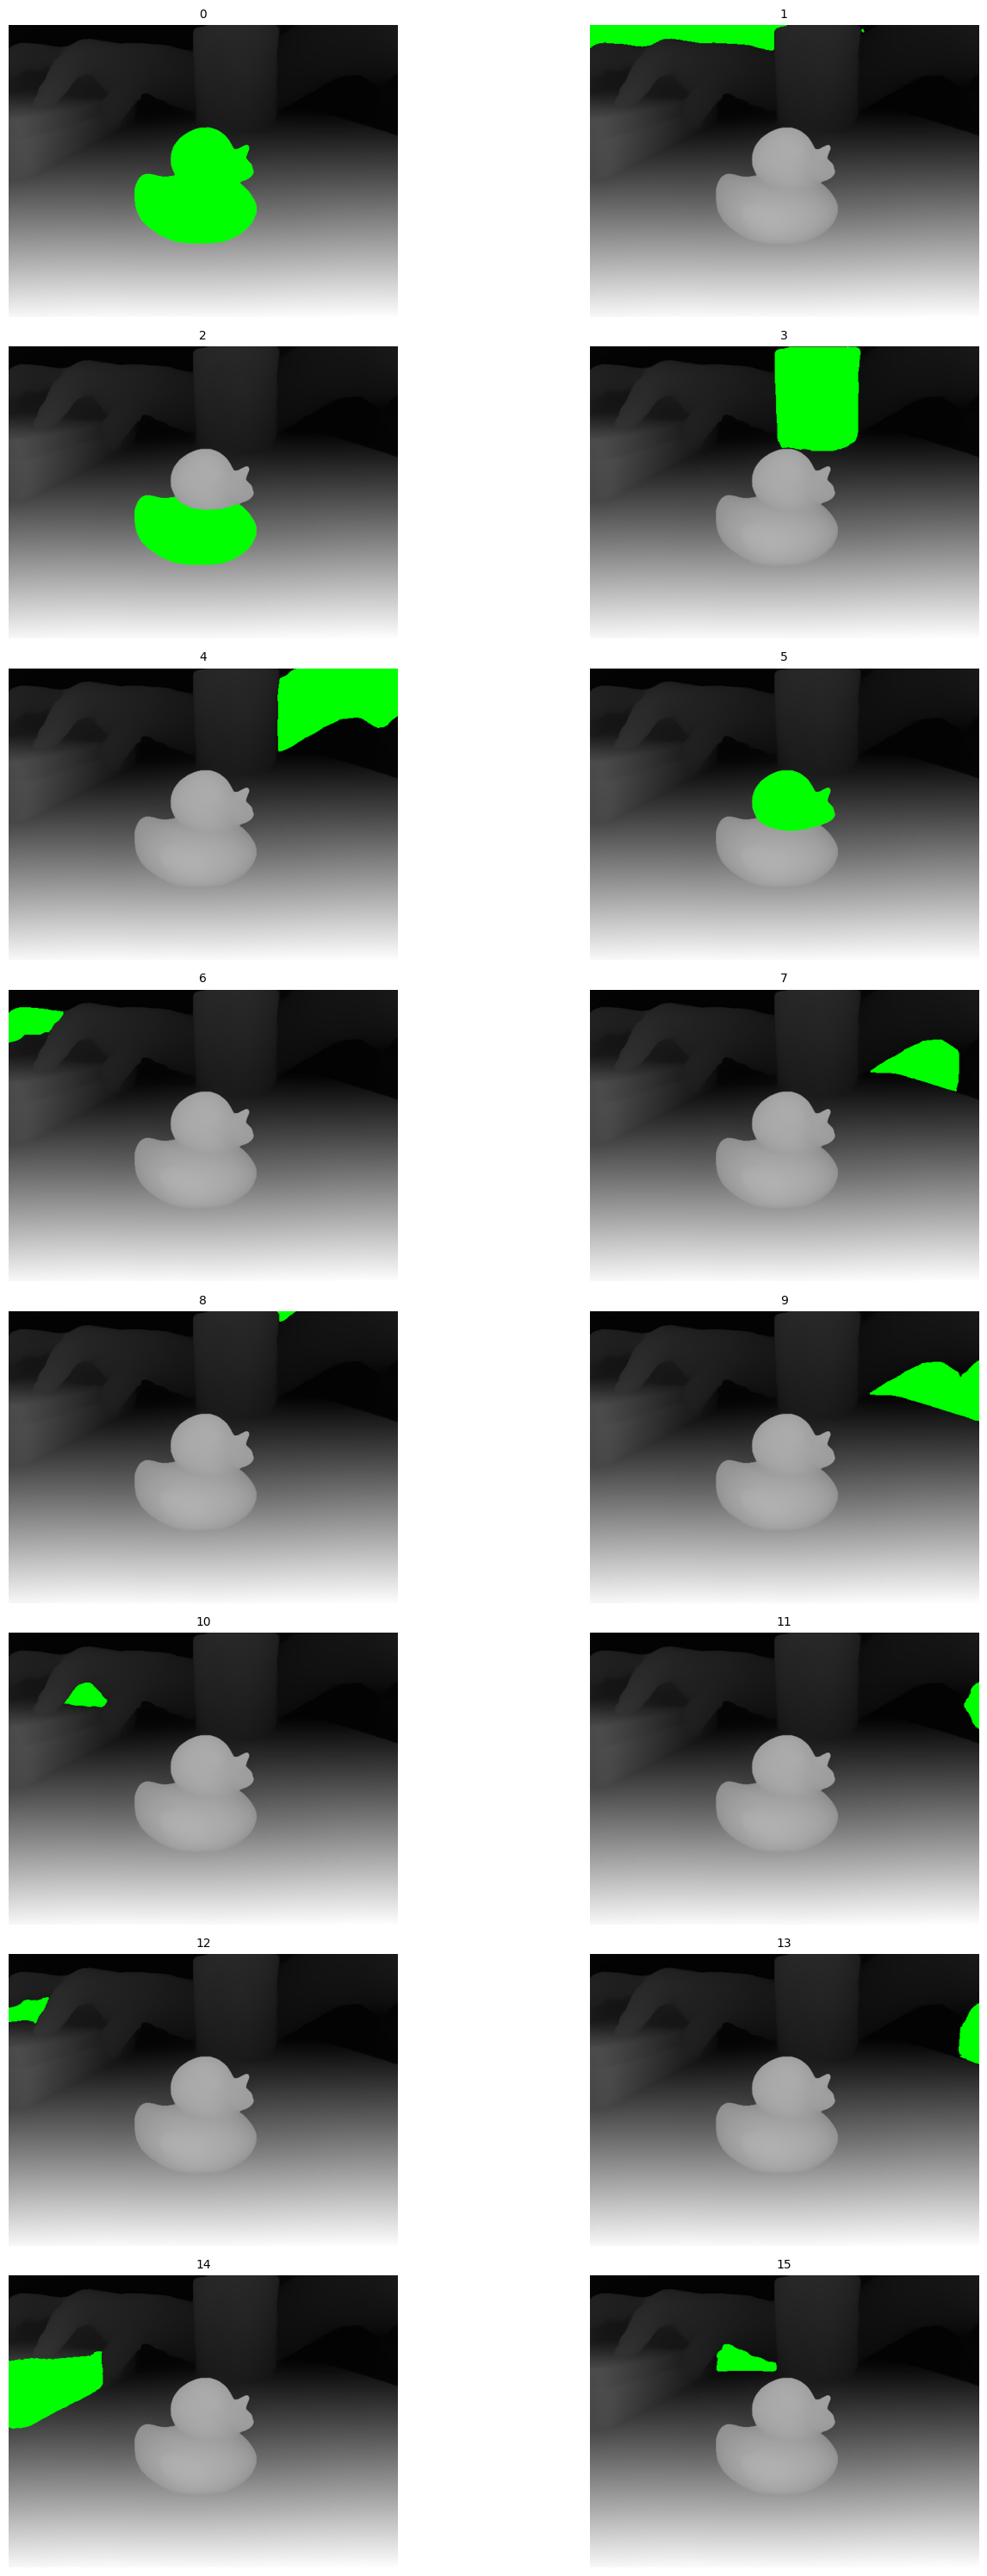

[INFO] Saved mask 0 → SDM-UniPS/data/duckiefinal/0.data/mask.png


In [95]:
### import cv2
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator
import torch
sam = sam_model_registry["vit_b"](checkpoint="sam_vit_b_01ec64.pth")
sam.to("cuda" if torch.cuda.is_available() else "cpu")
import numpy as np
import matplotlib.pyplot as plt
from transformers import pipeline
from PIL import Image
import torch
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator
import cv2
# --------------------------------------------------
# DEPTH ANYTHING (transfomers pipeline)
# --------------------------------------------------
pipe = pipeline(
    task="depth-estimation",
    model="depth-anything/Depth-Anything-V2-Small-hf"
)

def get_depth(image_pil):
    depth_pil = pipe(image_pil)["depth"]  # PIL Image
    depth_np = np.array(depth_pil).astype(np.float32)
    print(f"[INFO] depth map:", depth_np.shape)
    return depth_np


# --------------------------------------------------
# INPUT
# --------------------------------------------------
vista = input("Add view's number to mask: ")

img_path = f"SDM-UniPS/data/{obj_name}/{vista}.data/L (0).png"
print("Files inside folder:")
!ls "SDM-UniPS/data/{obj_name}/{vista}.data/"
# ========================================================================
# Load image
img_rgb = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

# --------------------------------------------------
# DEPTH
# --------------------------------------------------
depth_map = get_depth(Image.fromarray(img_rgb))

# Normalizar depth → 0–255 (SAM requiere imagen visual)
depth_norm = (depth_map - depth_map.min()) / (depth_map.max() - depth_map.min())
depth_uint8 = (depth_norm * 255).astype(np.uint8)
depth_rgb = cv2.cvtColor(depth_uint8, cv2.COLOR_GRAY2RGB)

# --------------------------------------------------
# LOAD SAM
# --------------------------------------------------
sam = sam_model_registry["vit_b"](checkpoint="sam_vit_b_01ec64.pth")
mask_generator = SamAutomaticMaskGenerator(
    sam,
    points_per_side=30,
    pred_iou_thresh=0.88,
    stability_score_thresh=0.92,
    min_mask_region_area=10
)

# --------------------------------------------------
# RUN SAM ON DEPTH MAP
# --------------------------------------------------
print("[INFO] Generating SAM masks on depth map...")
masks = mask_generator.generate(depth_rgb)
print(f"[INFO] Total masks: {len(masks)}")

# --------------------------------------------------
# SHOW 80 MASKS
# --------------------------------------------------
mask_dict = {}
max_masks = min(len(masks), 16)
n_cols, n_rows = 2,8

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 30))
axes = axes.flatten()

for idx in range(max_masks):
    m = masks[idx]
    mask_uint8 = (m['segmentation'].astype(np.uint8) * 255)

    display_img = depth_rgb.copy()
    display_img[mask_uint8 > 0] = [0, 255, 0]  # Verde

    axes[idx].imshow(display_img)
    axes[idx].set_title(f"{idx}", fontsize=10)
    axes[idx].axis('off')

    mask_dict[idx] = mask_uint8

for ax in axes[max_masks:]:
    ax.axis("off")

plt.tight_layout()
plt.show()

# --------------------------------------------------
# SELECT ONE MASK AND SAVE
# --------------------------------------------------
selected_idx = int(input(f"Select SAM mask index (0-{max_masks-1}): "))
selected_mask = mask_dict[selected_idx]

mask_path = f"SDM-UniPS/data/{obj_name}/{vista}.data/mask.png"
cv2.imwrite(mask_path, selected_mask)
print(f"[INFO] Saved mask {selected_idx} → {mask_path}")


### Get Normals from SDM Uni-PS

In [97]:
!python SDM-UniPS/main.py \
    --session_name duckiefinal  \
    --test_dir SDM-UniPS/data/duckiefinal \
    --checkpoint SDM-UniPS/checkpoint/ \
    --target normal


Starting a session: duckiefinal
target: normal

Loading pretrained model... SDM-UniPS/checkpoint//normal\nml.pytmodel 

canonical resolution: 256 x 256  
pixel samples: 10000

Exploring SDM-UniPS/data/duckiefinal
Found 1 objects!

Testing on 0.data
image index: [ 5  9  0  6  2 10  7  8  1  4]
original crop size: 216 x 216
resized crop size: 512 x 512
number of images: 10 / 10 (max)

Recovering normal map(s) 1 / 1
Prediction finished (Elapsed time is 7.801 sec)

Execute the following script to render a video under new lighting conditions based on the generated BRDF and normal map.

        python sdm_unips/relighting.py --datadir ./duckiefinal/results/0.data



In [98]:
import torch
import numpy as np
import scipy.sparse
import scipy.sparse.linalg
def comp_depth_4edge_sparse(mask, normal):
    if isinstance(mask, torch.Tensor):
        mask = mask.cpu().numpy()
    if isinstance(normal, torch.Tensor):
        normal = normal.cpu().numpy()

    h, w = mask.shape
    n_pixels = h * w

    mask = (mask > 0.5).astype(np.float32)
    indices = lambda i, j: i * w + j

    nx = normal[:, :, 0].flatten()
    ny = normal[:, :, 1].flatten()
    nz = normal[:, :, 2].flatten() + 1e-8

    p = -nx / nz
    q = -ny / nz

    rows = []
    cols = []
    data = []
    b = []

    for i in range(h):
        for j in range(w):
            if mask[i, j] == 0:
                continue
            idx = indices(i, j)

            if j < w - 1 and mask[i, j + 1] == 1:
                idx_r = idx + 1
                rows += [len(b), len(b)]
                cols += [idx, idx_r]
                data += [-1, 1]
                b.append(p[idx])

            if i < h - 1 and mask[i + 1, j] == 1:
                idx_d = idx + w
                rows += [len(b), len(b)]
                cols += [idx, idx_d]
                data += [-1, 1]
                b.append(q[idx])

            if j > 0 and mask[i, j - 1] == 1:
                idx_l = idx - 1
                rows += [len(b), len(b)]
                cols += [idx, idx_l]
                data += [1, -1]
                b.append(p[idx])

            if i > 0 and mask[i - 1, j] == 1:
                idx_u = idx - w
                rows += [len(b), len(b)]
                cols += [idx, idx_u]
                data += [1, -1]
                b.append(q[idx])

    A = scipy.sparse.coo_matrix((data, (rows, cols)), shape=(len(b), n_pixels))
    b = np.array(b)

    AtA = A.T @ A
    Atb = A.T @ b
    # x = scipy.sparse.linalg.spsolve(AtA, Atb)
    x = scipy.sparse.linalg.lsmr(A, b)[0]


    depth = x.reshape(h, w)
    depth -= depth.min()
    depth[mask == 0] = 0.0

    return depth

In [158]:
from utils import obj_functions as ob
def depth_process(normal_image, mask=None, og_image=None, path=None):
    # normal_map = ((normal_image / 255.0) * 2) - 1.0
    if mask is None:
        mask = np.ones(normal_image[:, :, 0].shape, dtype=np.uint8) * 255

    normal_image[mask == 0] = [0.0, 0.0, 0.0]

    # normal_image = ((normal_image + 1) / 2) * 255
    print(f"mask.shape in depth_process: {mask.shape}")
    normal = normal_image[:, :, :]
    normal[:, :, 1] = normal_image.copy()[:, :, 1] * -1

    #####################################################
    # 3. compute depth 4 edge
    #####################################################
    depth = comp_depth_4edge_sparse(mask, normal)

    if depth.ndim == 2:
        depth = depth[:, :, None]

    ver, tri = ob.Depth2VerTri(depth, mask)

    temp_albedo = og_image.astype(np.uint8)

    ob.save_as_ply(f"{path}/normals_recover.ply", depth, normal, temp_albedo, mask, tri)

    depth_norm = (1.0 - (depth / np.max(depth))) * 255
    depth_image = depth_norm.astype(np.uint8)

    return depth


def normals_from_depth(depth):
    dzdx = np.gradient(depth, axis=1)
    dzdy = np.gradient(depth, axis=0)

    normals = np.dstack((-dzdx, -dzdy, np.ones_like(depth)))
    norms = np.linalg.norm(normals, axis=2, keepdims=True)
    normals /= np.clip(norms, 1e-8, None)
    normals[:, :, 1] *= -1
    return normals


mask.shape in depth_process: (480, 640)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.999918459423893..1.0].


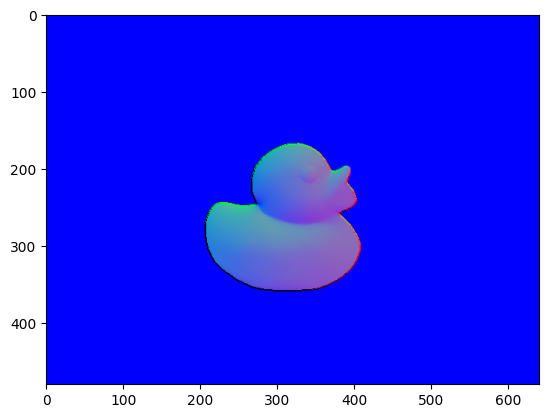

In [161]:
def normals2depth(path_results, path_mask):
    for vista in os.listdir(path_results):
        normal = plt.imread(os.path.join(path_results, vista, 'normal.png'))
        mask = cv2.imread(os.path.join(path_mask, vista, 'mask.png'), cv2.IMREAD_UNCHANGED)
        color_img =  cv2.imread(os.path.join(path_mask, vista, 'L (1).png'), cv2.IMREAD_UNCHANGED)
        normals = np.zeros_like(normal)
        normals[mask > 0] = normal[mask > 0]
        if mask.ndim == 3:
            mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        depth = depth_process(normals, mask, og_image=color_img, path=os.path.join(path_results, vista))
        plt.imshow(depth, cmap='gray')
        final_normals = normals_from_depth(depth)
        plt.imshow(final_normals)
        plt.show()
normals2depth('duckiefinal/results', path_mask='SDM-UniPS/data/duckiefinal')




## Download

In [91]:
import shutil
from google.colab import files

root_folder = "SDM-UniPS/data/duck"
zip_name = "duck_all_data"
shutil.make_archive(base_name=zip_name, format='zip', root_dir=root_folder)
files.download(f"{zip_name}.zip")

root_folder_results = "duck/results"
zip_name_results = "normals_duck_all_data"
shutil.make_archive(base_name=zip_name_results, format='zip', root_dir=root_folder_results)
files.download(f"{zip_name_results}.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>